In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from matplotlib.colors import ListedColormap

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA 

# classification algorithm
from sklearn import svm 

# metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc, roc_auc_score

# model selection and parameter tuning
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# yellowbrick library  #pip install yellowbrick
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport

In [4]:
# example dataset
from sklearn.datasets import make_blobs

In [5]:
# appearence
sns.set_theme(style='darkgrid')
sns.set(rc={"figure.figsize":(12, 8)})
activities = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
c = ['#f05039', '#e57a77', '#eebab4', '#1f449c', '#3d65a5', '#7ca1cc']
col = ListedColormap(sns.color_palette(c).as_hex())

### functions

In [6]:
def data_encoder(train, test):
    """Encodes the sets. Takes as arguments train-test sets. 
    Fits on train and transforms both."""
    encoder = OneHotEncoder()
    encoder.fit(train)
    train_encoded = encoder.transform(train).toarray()
    test_encoded = encoder.transform(test).toarray()
    return train_encoded, test_encoded


def data_scaler(train, test, scaler):
    """Scales the datasets. Takes as arguments train-test sets and a scaler.
    Fits on train set and transforms both."""
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return train_scaled, test_scaled

In [7]:
csv_names = {
    'monk1': ['monks-1.train', 'monks-1.test'] 
    ,'monk2': ['monks-2.train', 'monks-2.test']
    ,'monk3': ['monks-3.train', 'monks-3.test']
    ,'cup': ['ML-CUP22-TR.csv', 'ML-CUP22-TS.csv']
    ,'internal_cup': ['ML-CUP22-INTERNAL-TR.csv', 'ML-CUP22-INTERNAL-TS.csv']
 }

def import_df(string, type):
    """Imports a dataframe from csv file. 
    type = 'monk' OR 'cup'. 
    sting = .csv path"""
    if type == 'monk':
        dataframe = pd.read_csv('../data/{}'.format(string), header=None, delimiter=' ')
    elif type == 'cup':
        dataframe = pd.read_csv('../data/{}'.format(string), header=None)
        dataframe.drop(0, axis=1, inplace=True)
    return dataframe

def set_attributes(dataframe, type):
    """Takes a dataframe and sets corresponding attribute names."""
    if type == 'monk':
        df = dataframe.drop(columns=0)
        columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
        df.columns = columns
    else:
        df = dataframe
    return df #..

def X_y_split(dataframe, type):
    """Split dataframe in X and y sets. Takes dataframe as an argument.
    In case of cup it gives y_1 and y_2."""
    
    if type == 'monk':
        X_df = dataframe.copy()
        y_df_1 = X_df['class']
        X_df = X_df.drop(columns='id')
        X_df = X_df.drop(columns='class')
        X_df = X_df.values  
        y_df_2 = []
    elif type == 'cup':
        X_df = dataframe.iloc[:, :9].to_numpy().astype(np.float64)
        y_df_1 = dataframe.iloc[:, 9:10].to_numpy().astype(np.float64)
        y_df_2 = dataframe.iloc[:, 10:].to_numpy().astype(np.float64)
    return X_df, y_df_1, y_df_2


def load_data(string, type):
    """Loads Dataframe"""
    dataframe = import_df(string, type)
    df = set_attributes(dataframe, type)
    X_df, y_df_1, y_df_2 = X_y_split(df, type)
    return X_df, y_df_1, y_df_2

## MONKs

Attribute information:
* class: 0, 1 
* a1:    1, 2, 3
* a2:    1, 2, 3
* a3:    1, 2
* a4:    1, 2, 3
* a5:    1, 2, 3, 4
* a6:    1, 2
* Id:    (A unique symbol for each instance)

### Load & Prepare MONKs Data

In [83]:
X_train1, y_train1, empty  = load_data(csv_names['monk1'][0], 'monk')
X_test1, y_test1, empty    = load_data(csv_names['monk1'][1], 'monk')
X_train2, y_train2, empty  = load_data(csv_names['monk2'][0], 'monk')
X_test2, y_test2, empty    = load_data(csv_names['monk2'][1], 'monk')
X_train3, y_train3, empty  = load_data(csv_names['monk3'][0], 'monk')
X_test3, y_test3, empty    = load_data(csv_names['monk3'][1], 'monk')

In [84]:
len(X_train1)/len(X_test1), len(X_train2)/len(X_test2), len(X_train3)/len(X_test3)  

(0.28703703703703703, 0.3912037037037037, 0.2824074074074074)

In [88]:
train1 = import_df(csv_names[0])
train1 = set_attributes(train1)

In [89]:
#print('test: ', test1['a1'].value_counts()) 
print('train: ', train1['a1'].value_counts())

train:  1    45
2    42
3    37
Name: a1, dtype: int64


### Encoding & Scaling 

In [91]:
X_train1_encoded, X_test1_encoded = data_encoder(X_train1, X_test1)
X_train2_encoded, X_test2_encoded = data_encoder(X_train2, X_test2)
X_train3_encoded, X_test3_encoded = data_encoder(X_train3, X_test3)

X_train1_encoded.shape

(124, 17)

In [92]:
scaler = StandardScaler() # MinMaxScaler()
X_train1_sc, X_test1_sc = data_scaler(X_train1, X_test1, scaler)
X_train2_sc, X_test2_sc = data_scaler(X_train2, X_test2, scaler)
X_train3_sc, X_test3_sc = data_scaler(X_train3, X_test3, scaler)

X_train1_sc.shape

(124, 6)

### Plotting

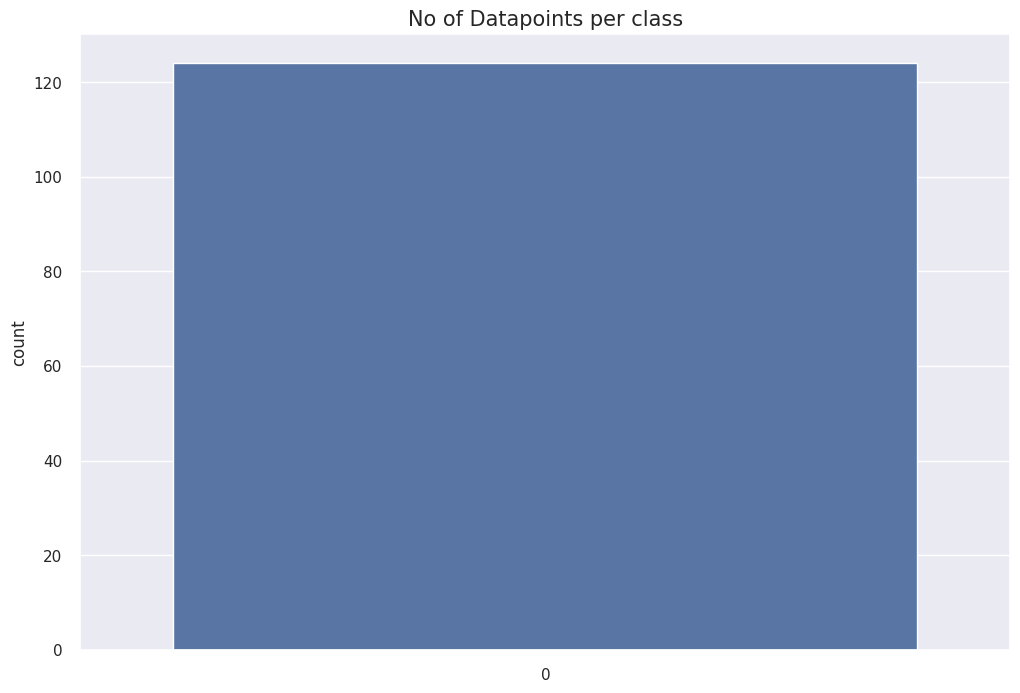

In [16]:
plt.title('No of Datapoints per class', fontsize=15)
sns.countplot(train1['class'])
plt.xticks(rotation=0)
plt.show()

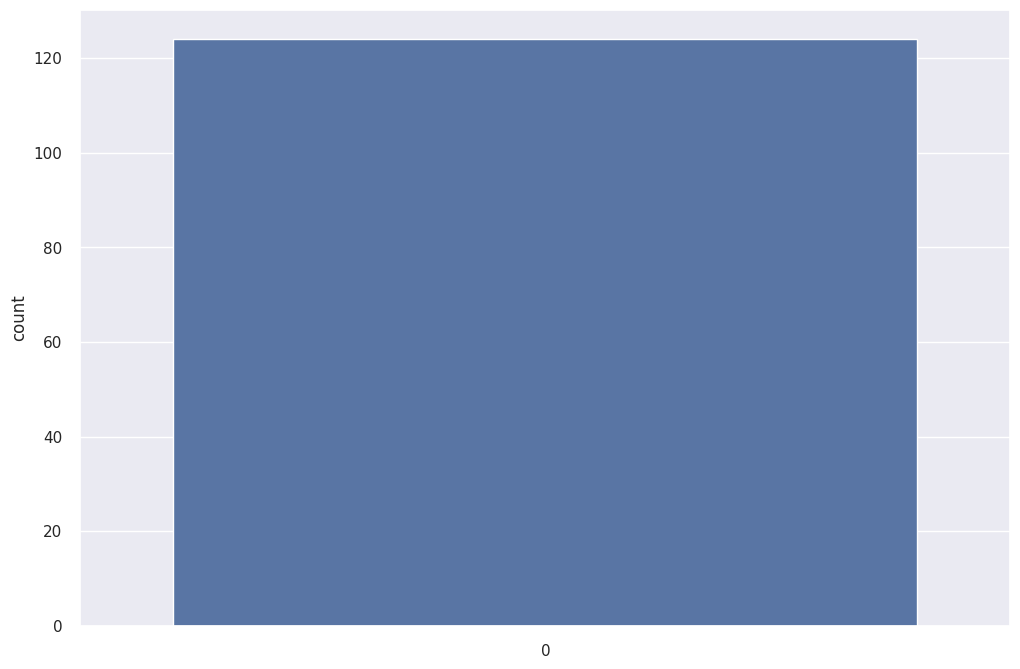

In [17]:
sns.countplot(train1['a5'])
plt.xticks(rotation=0)
plt.show()

In [18]:
# representing only 6 dimensions 
train1_dims = train1[['a1',	'a2', 'a3',	'a4', 'a5',	'a6']]
train1_dims.head()

,a1,a2,a3,a4,a5,a6
0,1,1,1,1,3,1
1,1,1,1,1,3,2
2,1,1,1,3,2,1
3,1,1,1,3,3,2
4,1,1,2,1,2,1


<AxesSubplot: >

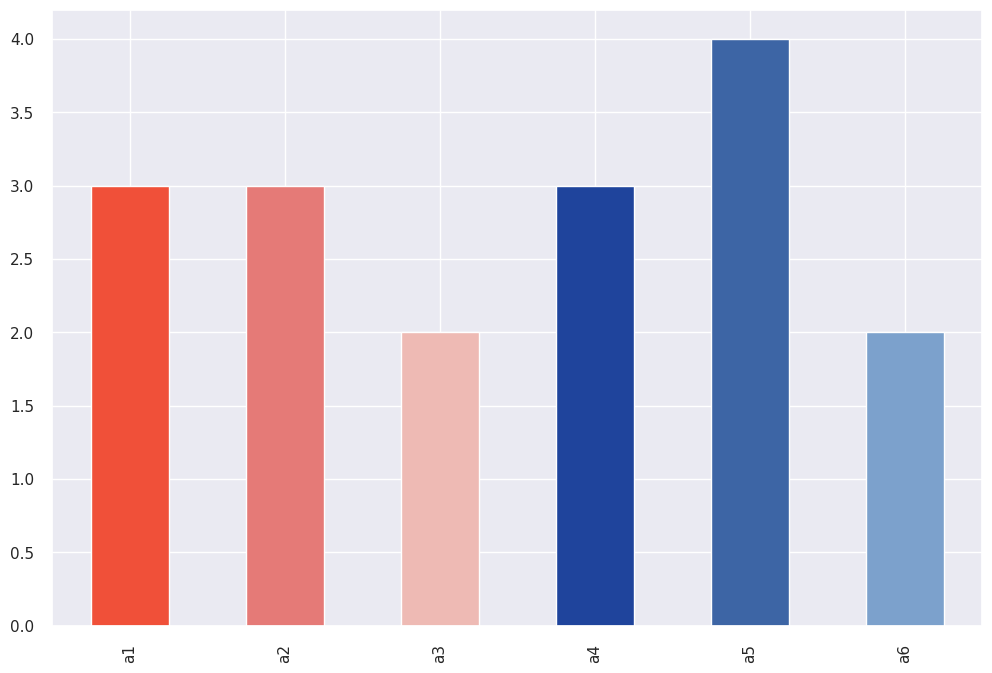

In [19]:
unique = train1_dims.nunique()
unique.plot(kind='bar', 
           color=c)

In [20]:
train1_mean_std = train1_dims.agg([np.mean, np.std])
train1_mean_std

,a1,a2,a3,a4,a5,a6
mean,1.935484,2.096774,1.475806,2.008065,2.556452,1.548387
std,0.813923,0.810694,0.501440,0.831259,1.128366,0.499672


<AxesSubplot: >

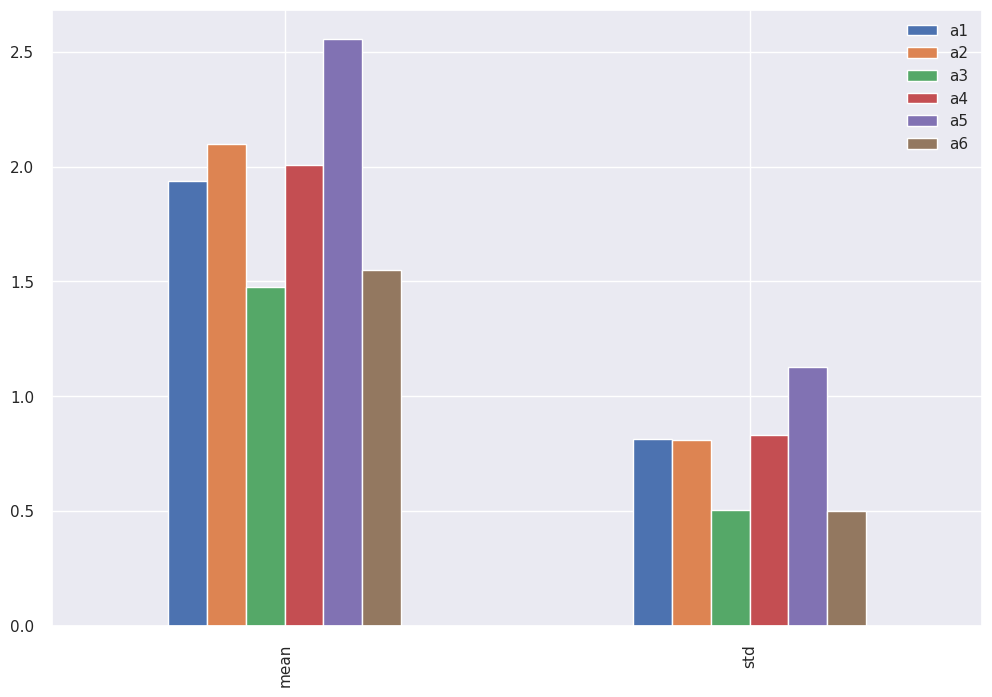

In [21]:
train1_mean_std.plot(kind = 'bar')

In [22]:
# correlation of only 6 dimensions 
train1_corr = train1_dims.corr()
train1_corr.style.background_gradient(cmap='viridis') # Blues cubehelix RdBu PuOr viridis binary jet rainbow gray

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [ ]:
# trying scatter plot of highly correlated attributes
plt.scatter(train1[train1['class'] == 0]['a1'],
            train1[train1['class'] == 0]['a5'], color=c[0], marker='*', label='class 0')
plt.scatter(train1[train1['class'] == 1]['a1'],
            train1[train1['class'] == 1]['a5'], color=c[5], label='class 1')
plt.xlabel('a1')
plt.ylabel('a5')
plt.legend()
plt.show()

In [ ]:
train1['class'].value_counts().plot(kind='pie', y='count', #figsize=(9,9),
                                #title='Class', 
                                #autopct='%1.0f%%',
                                autopct = "%.2f%%",
                                fontsize = 24, 
                                )
plt.show()


In [ ]:
train1['a5'].value_counts().plot(kind='pie', y='count', #figsize=(9,9),
                                #title='Class', 
                                #autopct='%1.0f%%',
                                autopct = "%.2f%%",
                                fontsize = 24, 
                                )
plt.show()


In [ ]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a1'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a1', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(1, color = "lightblue", linestyle='--')
plt.axvline(3, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

In [ ]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a2'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a2', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(2.98, color = "lightblue", linestyle='--')
plt.axvline(3, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

In [ ]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a3'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a3', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(2, color = "lightblue", linestyle='--')
plt.axvline(1, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

In [ ]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a4'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a4', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(2, color = "lightblue", linestyle='--')
plt.axvline(1, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

In [ ]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a5'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a5', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(4, color = "lightblue", linestyle='--')
plt.axvline(1, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

In [ ]:
class_values = sorted(train1['class'].unique())
for val in class_values:
    train1[train1['class'] == val]['a6'].plot(kind='kde') #Generate Kernel Density Estimate plot using Gaussian kernels
plt.xlabel('a6', fontsize = 24)
plt.ylabel('Density', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axvline(2, color = "lightblue", linestyle='--')
plt.axvline(1, color = "orange", linestyle='--')
legend = plt.legend(('0', '1'), loc='best', fontsize = 20, fancybox=True,shadow=True)
legend.set_title("Class", prop={'size':18})
plt.show()

### 1. SVM

Parameters to Tune:
* Kernel {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}
* Regularization - C - tells the SVM optimization how much we want to avoid misclassifying each training example
* Gamma {'scale', 'auto'} 
        Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
        - if ``gamma='scale'`` (default) is passed then it uses
          1 / (n_features * X.var()) as value of gamma,
        - if 'auto', uses 1 / n_features.
* Margin 

In [93]:
#Create a svm Classifier
clf = svm.SVC(random_state=42) # Linear Kernel

#Train the model using the train 1 set
clf.fit(X_train1_encoded, y_train1)

#Predict the response for test dataset
y_pred1 = clf.predict(X_test1_encoded)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.8912037037037037
F1-score [0.89485459 0.88729017]
              precision    recall  f1-score   support

           0       0.87      0.93      0.89       216
           1       0.92      0.86      0.89       216

    accuracy                           0.89       432
   macro avg       0.89      0.89      0.89       432
weighted avg       0.89      0.89      0.89       432



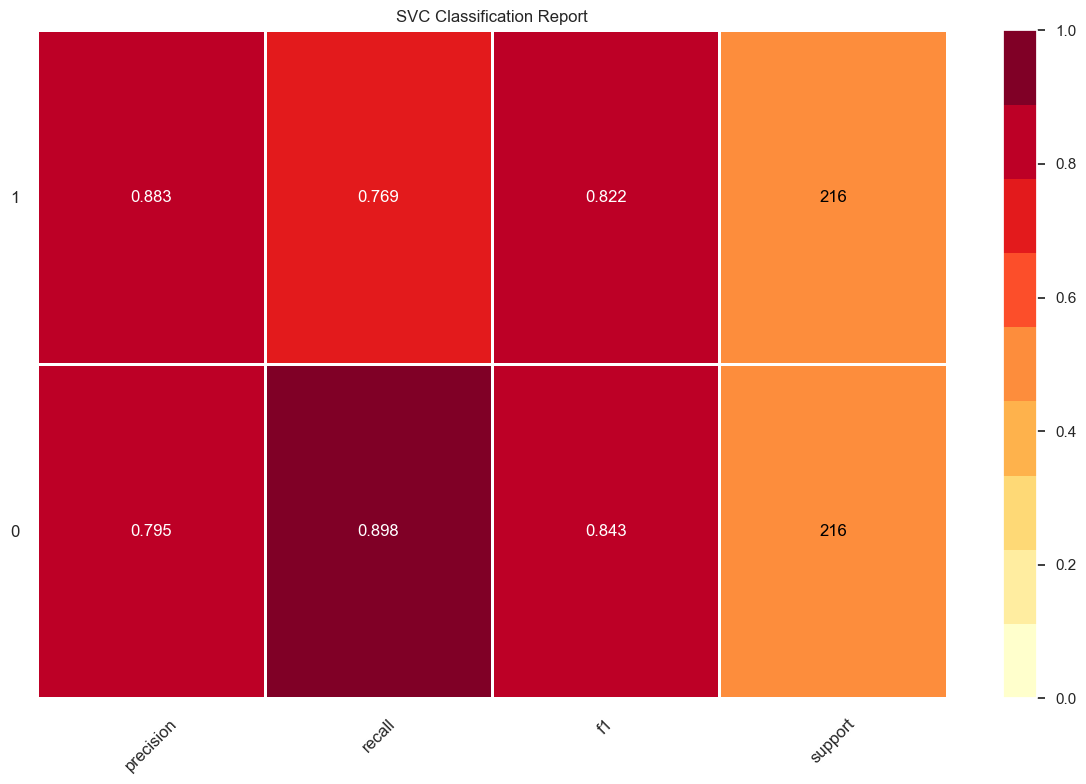

<AxesSubplot:title={'center':'SVC Classification Report'}>

In [94]:
clf = svm.SVC(random_state=42) # Linear Kernel
## Specify the target classes
#classes = ["0", "1"]

visualizer = ClassificationReport(clf, support=True) #classes=classes, 

visualizer.fit(X_train1, y_train1)        # Fit the visualizer and the model
visualizer.score(X_test1, y_test1)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [95]:
#Train the model using the train 2 set
clf.fit(X_train2, y_train2)

#Predict the response for test dataset
y_pred2 = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test2, y_pred2))
print('F1-score %s' % f1_score(y_test2, y_pred2, average=None))
print(classification_report(y_test2, y_pred2))

Accuracy 0.6805555555555556
F1-score [0.78504673 0.37837838]
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       290
           1       0.53      0.30      0.38       142

    accuracy                           0.68       432
   macro avg       0.62      0.58      0.58       432
weighted avg       0.65      0.68      0.65       432



In [96]:
#Train the model using the train 3 set
clf.fit(X_train3, y_train3)

#Predict the response for test dataset
y_pred3 = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test3, y_pred3))
print('F1-score %s' % f1_score(y_test3, y_pred3, average=None))
print(classification_report(y_test3, y_pred3))

Accuracy 0.9699074074074074
F1-score [0.96912114 0.97065463]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.94      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



### Hyperparameter Tuning for SVM

In [22]:
from sklearn.model_selection import StratifiedKFold

def ParameterTune(X_train, y_train, X_test, y_test):
  #Create a svm Classifier
  clf = svm.SVC(random_state=42)

  # Grid Search
  param_grid = [
    {'C': range(1,100)
    ,'kernel': ['linear', 'rbf', 'poly']
    #,'gamma': range(1e-2, 1e-5)
    },
    {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000, 10000]
    ,'kernel': ['linear', 'rbf', 'poly']
    ,'gamma': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000, 10000]
    }
  ]

    
  cv = StratifiedKFold(n_splits=5, shuffle=True)    

  grid_search = GridSearchCV(clf, param_grid=param_grid, cv=cv, n_jobs=20)
  grid_search.fit(X_train, y_train)
  clf = grid_search.best_estimator_

  y_pred = clf.predict(X_test)
  #y_score1 = clf.predict_proba(X_test)

  model = grid_search.best_estimator_
  #accuracy = accuracy_score(y_test, y_pred)
  #f1_score = f1_score(y_test, y_pred, average=None)
  #classification_rep = classification_report(y_test, y_pred)

  learning_curve = LearningCurve(model, scoring='accuracy')
  learning_curve.fit(X_train, y_train)  

  return y_test, y_pred, model, learning_curve #, accuracy, f1_score, classification_rep

Model:  SVC(C=10000, gamma=0.01, random_state=42)
Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



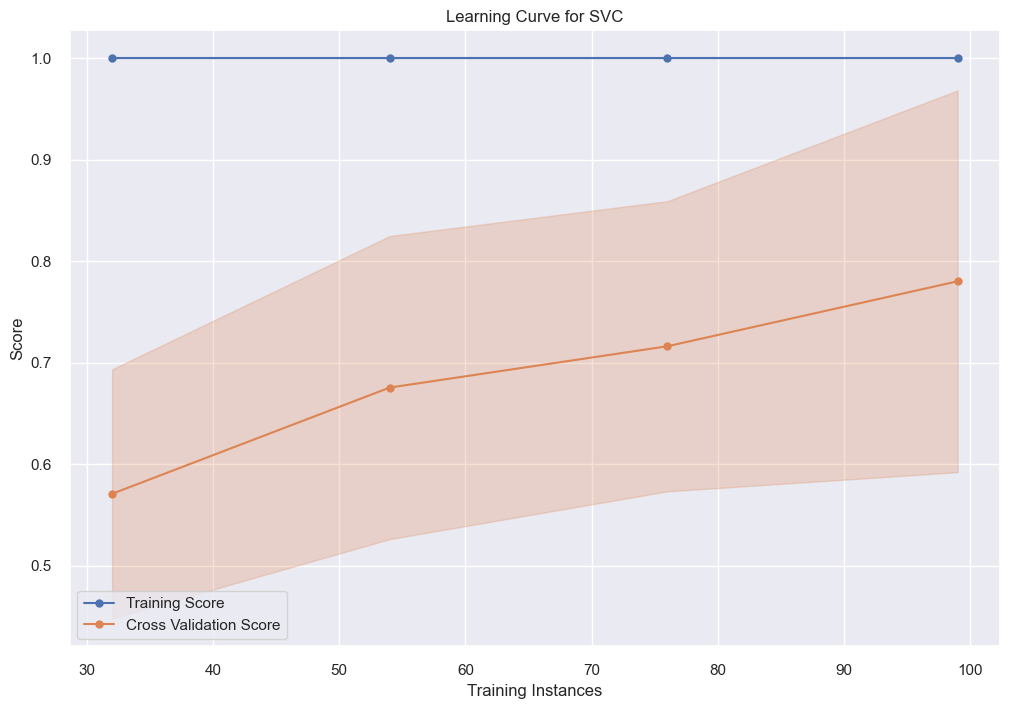

<AxesSubplot:title={'center':'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [23]:
y_test, y_pred, model, lc = ParameterTune(X_train1_encoded, y_train1, X_test1_encoded, y_test1)

print('Model: ', model)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

lc.show()

Model:  SVC(C=10000, gamma=0.01, random_state=42)
Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



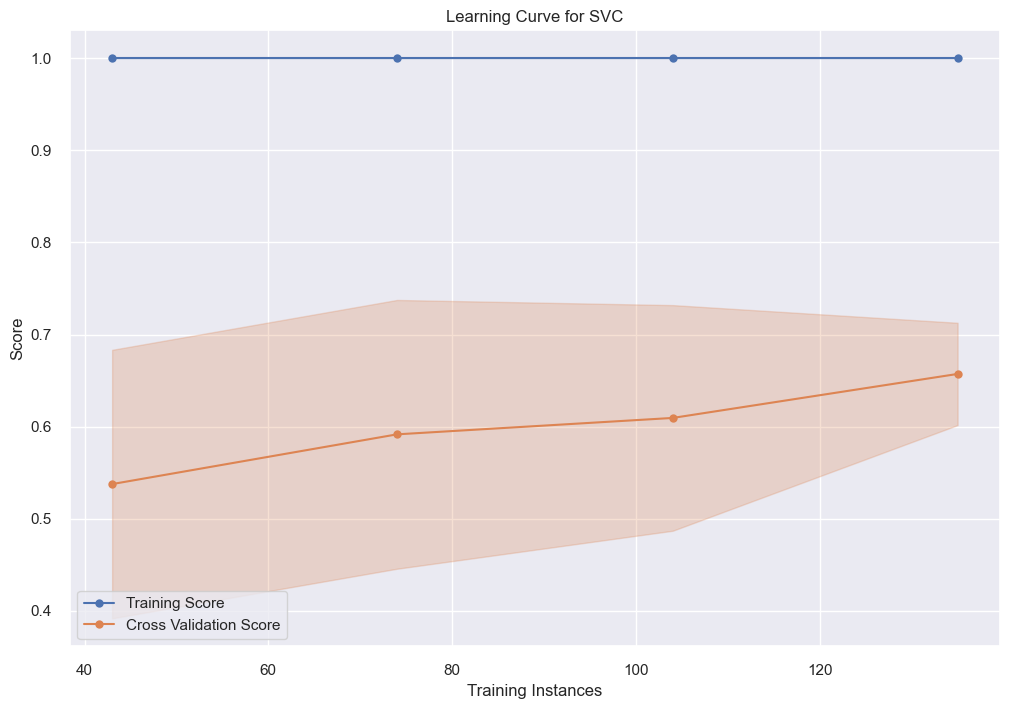

<AxesSubplot:title={'center':'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [24]:
y_test, y_pred, model, lc = ParameterTune(X_train2_encoded, y_train2, X_test2_encoded, y_test2)

print('Model: ', model)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

lc.show()

Model:  SVC(C=1, kernel='linear', random_state=42)
Accuracy 0.9722222222222222
F1-score [0.97142857 0.97297297]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



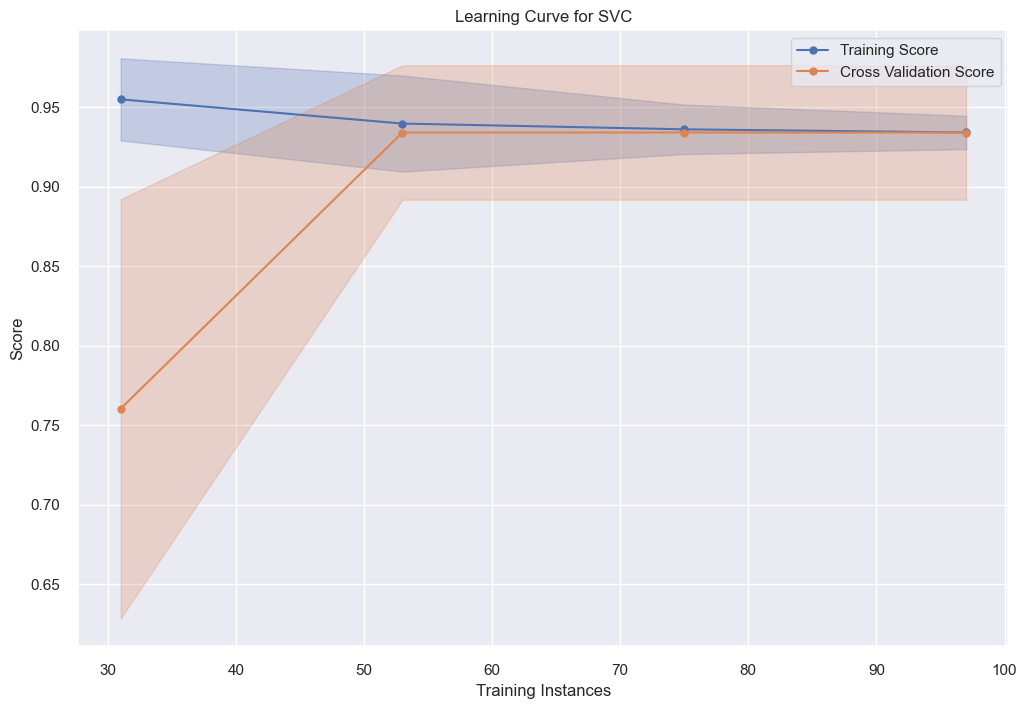

<AxesSubplot:title={'center':'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [25]:
y_test, y_pred, model, lc = ParameterTune(X_train3_encoded, y_train3, X_test3_encoded, y_test3)

print('Model: ', model)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

lc.show()

### Nested CV

In [ ]:
# Number of random trials
NUM_TRIALS = 30

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
model = svm.SVC(random_state = 42, kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_train1_encoded, y_train1)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_train1_encoded, y=y_train1, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

In [ ]:
#print('Parameters: ', clf.best_estimator_)

In [ ]:
# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on MONK Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

### 2. Linear SVM 

For linear SVM we need to take max two features to run the algorithm

#### Feature Selection

##### Univariate Feature Selection

In [ ]:
sel = SelectKBest(k=2)
X_train1_sel = sel.fit_transform(X_train1_mm, y_train1)
X_test1_sel = sel.fit_transform(X_test1_mm, y_test1)
X_train1_sel.shape, X_test1_sel.shape

In [ ]:
X_train_sel_df = pd.DataFrame({'x':X_train1_sel[:,0], 'y':X_train1_sel[:,1] ,'class':y_train1})
X_train_sel_df

##### PCA

In [ ]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X_train1)
X_train1_pca = pca.transform(X_train1)
X_test1_pca = pca.transform(X_test1)

#### linearSVC  (?sucks)

In [ ]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)
#clf = svm.SVC(kernel='linear',random_state=42)

clf.fit(X_train1_sel, y_train1)
y_pred1 = clf.predict(X_test1_sel)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

In [ ]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

clf.fit(X_train1_pca, y_train1)
y_pred1 = clf.predict(X_test1_pca)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

In [ ]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train1_sel, y_train1)
clf = grid_search.best_estimator_

y_pred1 = clf.predict(X_test1_sel)
#y_score1 = clf.predict_proba(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

In [ ]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=50) 
# cv : int, cross-validation generator or an iterable, default=None
#         Determines the cross-validation splitting strategy.

grid_search.fit(X_train1_st, y_train1)
clf = grid_search.best_estimator_

y_pred1 = clf.predict(X_test1_st)
#y_score1 = clf.predict_proba(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

In [ ]:
clf

In [ ]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=50) 
# cv : int, cross-validation generator or an iterable, default=None
#         Determines the cross-validation splitting strategy.

grid_search.fit(X_train1_mm, y_train1)
clf = grid_search.best_estimator_

y_pred1 = clf.predict(X_test1_mm)
#y_score1 = clf.predict_proba(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

In [ ]:
lc3_viz = LearningCurve(clf, scoring='accuracy')
lc3_viz.fit(X_train1_mm, y_train1)
lc3_viz.show()

In [ ]:
X, y = make_blobs(n_samples=40, centers=2, random_state=42)
#X = X_train1
#y = y_train1

plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = svm.LinearSVC(C=C, loss="hinge", random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    support_vector_indices = np.where((2 * y - 1) * decision_function <= 1)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
    #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
plt.tight_layout()
plt.show()

### 3. SVM with Linear Kernel

In [ ]:
#Create a svm Classifier
clf = svm.SVC(random_state=42, kernel='linear')

# Grid Search
param_grid = [
  {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, n_jobs=50)
grid_search.fit(X_train1, y_train1)
grid_search.best_estimator_

In [ ]:
#Create a svm Classifier
clf = svm.SVC(random_state=42, kernel='linear', C=0.05)

clf.fit(X_train1, y_train1)

y_pred1 = clf.predict(X_test1)
#y_score1 = clf.predict_proba(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

In [ ]:
lc_1 = LearningCurve(clf, scoring='accuracy')
lc_1.fit(X_train1, y_train1)
lc_1.show()

### Model Evaluation

In [ ]:
#from scikitplot.metrics import plot_roc
#from scikitplot.metrics import plot_precision_recall
#from scikitplot.metrics import plot_cumulative_gain
#from scikitplot.metrics import plot_lift_curve

#### Confusion Matrix

In [ ]:
cf = confusion_matrix(y_test1, y_pred1)
cf

In [ ]:
activities = ['0', '1']

ax = plt.subplots(figsize = (12,10))
ax = sns.heatmap(cf, annot=True, fmt="d", annot_kws={"size": 20}, linewidths=4, cmap="Blues")
ax.set_xticklabels(activities, fontsize=10)
ax.set_xlabel('Predicted Class', fontsize=14)
ax.set_yticklabels(activities, fontsize=10)
ax.set_ylabel('True Class', fontsize=14)

plt.show()

## ML-CUP22

### Read datasets

In [8]:
X_train_cup, y_train_cup_1, y_train_cup_2  = load_data(csv_names['cup'][0], 'cup')
X_test_cup, y_test_cup_1, y_test_cup_2  = load_data(csv_names['cup'][1], 'cup')

X_train_int_cup, y_train_int_cup_1, y_train_int_cup_2  = load_data(csv_names['internal_cup'][0], 'cup')
X_test_int_cup, y_test_int_cup_1, y_test_int_cup_2  = load_data(csv_names['internal_cup'][1], 'cup')

In [9]:
print(X_train_cup.shape, y_train_cup_1.shape, y_train_cup_2.shape) 
print(X_test_cup.shape, y_test_cup_1.shape, y_test_cup_2.shape)
print(X_train_int_cup.shape, y_train_int_cup_1.shape, y_train_int_cup_2.shape)
print(X_test_int_cup.shape, y_test_int_cup_1.shape, y_test_int_cup_2.shape)

(1492, 9) (1492, 1) (1492, 1)
(529, 9) (529, 0) (529, 0)
(1194, 9) (1194, 1) (1194, 1)
(298, 9) (298, 1) (298, 1)


### Scaling

In [10]:
minmax = StandardScaler()
X_train_cup_scaled, X_test_cup_scaled = data_scaler(X_train_int_cup, X_test_int_cup, minmax)
#minmax = MinMaxScaler()
#y_train_cup1_scaled, y_test_cup1_scaled = data_scaler(y_train_int_cup_1, y_test_int_cup_1, minmax)
#minmax = MinMaxScaler()
#y_train_cup2_scaled, y_test_cup2_scaled = data_scaler(y_train_int_cup_2, y_test_int_cup_2, minmax)

In [11]:
X_train_cup_scaled.shape, X_test_cup_scaled.shape

((1194, 9), (298, 9))

In [12]:
X_train_cup_scaled

array([[-1.75465767,  1.52632634, -1.09040812, ..., -0.03000727,
         0.28635912, -1.27334492],
       [-0.94508875,  0.70804759, -0.74396566, ..., -0.68803179,
         1.47525578, -1.13824079],
       [ 1.07201796, -1.67220704,  0.43855985, ..., -0.93543641,
        -1.4018833 ,  0.54716499],
       ...,
       [ 1.51448542, -1.99134622,  0.17665589, ..., -1.46384714,
        -1.42907601, -0.09833872],
       [ 0.1578718 ,  0.14978996,  2.15280454, ...,  0.36838859,
         0.27243016,  0.04115403],
       [-1.75099708,  0.88572018, -0.59256539, ..., -0.21391298,
         0.33897976, -1.42525419]])

In [13]:
# the final sets scaled
st_scaler = StandardScaler()
X_tr_scaled, X_ts_scaled = data_scaler(X_train_cup, X_test_cup, st_scaler)

#minmax = StandardScaler()
#y_tr1_scaled = minmax.fit_transform(y_train_cup_1)
#y_tr2_scaled = minmax.fit_transform(y_train_cup_2)

### SVR

In [14]:
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from sklearn.metrics import * 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mee(y_true, y_pred):
    return np.mean(np.sqrt(np.sum(np.square(y_true - y_pred), axis=1)))

In [19]:
def ParameterTune_Regression(X_train, y_train, X_test, y_test):
  #Create a svm Regressor
  reg = svm.SVR()

  # Grid Search
  param_grid = [
    {
    'C': [0.01, 0.1, 0.5, 1.0, 10.0]
    ,'kernel': ['linear', 'rbf', 'poly']
    #,'gamma': ['scale', 'auto']  
    ,'gamma': [0.1, 0.5, 1]
    ,'epsilon': [0.1,0.2,0.5,0.3]
    }
    #,
    #{
    #'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0, 100.0, 1000.0]
    #,'kernel': ['linear', 'rbf'] # , 'poly' --> takes a lot of execution time with many other params
    #,'gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000]
    #,'epsilon': [0.1,0.2,0.5,0.3]
    #}
  ]

  cv = KFold(n_splits=5, shuffle=True, random_state=42)
  MEE = make_scorer(mee, greater_is_better=False)

  grid_search = GridSearchCV(reg, param_grid=param_grid, cv=cv, verbose=4, n_jobs=1, refit=True, scoring=MEE) # n_jobs=-1 --> sets to num. of processors available 
  model = grid_search.fit(X_train, y_train)

  #y_pred = model.predict(X_train)
  
  val_score = model.best_score_

  return model, val_score #, learning_curve #, accuracy, f1_score, classification_rep

#### for 1st label

In [17]:
y_train_int_cup_1

array([[22.222923],
       [18.88552 ],
       [ 4.587627],
       ...,
       [ 4.982587],
       [10.887319],
       [18.453878]])

In [ ]:
model, score = ParameterTune_Regression(X_train_cup_scaled, y_train_int_cup_1, X_test_cup_scaled, y_test_int_cup_1)

In [ ]:
print('Validation MEE: ', score)

In [47]:
model.best_estimator_

SVR(C=0.5, gamma=1)

In [50]:
# retraining on whole train set  ??
model.fit(X_tr_scaled, y_train_cup_1)
y_pred1 = model.predict(X_ts_scaled)


Fitting 5 folds for each of 828 candidates, totalling 4140 fits


In [62]:
## Checking the score for all parameters
#print("Grid scores on training set:")
#means = grid.cv_results_['mean_test_score']
#stds = grid.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

#### for 2nd label

In [63]:
model2, score2 = ParameterTune_Regression(X_train_cup_scaled, y_train_int_cup_2, X_test_cup_scaled,  y_train_int_cup_2)

Fitting 5 folds for each of 828 candidates, totalling 4140 fits
MEE:  5.22063356692569
MAE:  0.06713724495166341
MSE:  0.007532855513600758
R2:  0.8547046143263486


In [ ]:
print('Validation MEE: ', score2)

In [65]:
model2

SVR(gamma=1)

In [ ]:
# internal train
y_pred1 = model.predict(X_train_cup_scaled)
y_pred2 = model2.predict(X_train_cup_scaled)

y_pred = np.array([y_pred1, y_pred2])
y_pred = y_pred.reshape(-1,2)

print('MEE: ', mee(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

In [ ]:
# Internal test 
y_pred1 = model.predict(X_test_cup_scaled)
y_pred2 = model2.predict(X_test_cup_scaled)

y_pred = np.array([y_pred1, y_pred2])
y_pred = y_pred.reshape(-1,2)

print('MEE: ', mee(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

### Saving the Model

In [ ]:
from joblib import dump, load
dump(model, '../Models/model1.joblib') 
dump(model2, '../Models/model2.joblib') 

In [ ]:
# loading the model 
#model1 = load('../Models/model1.joblib') 